# **Advanced Models: GloVe Debagree Dictionary Analysis**

In [30]:
!pip install sentence-transformers==2.2.2
!pip install huggingface_hub==0.25.1

!pip install wordcloud
!pip install adjustText

  Using cached huggingface_hub-0.25.1-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.25.1-py3-none-any.whl (436 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.53.0 requires huggingface-hub<1.0,>=0.30.0, but you have huggingface-hub 0.25.1 which is incompatible.


In [31]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from sklearn.feature_extraction.text import TfidfVectorizer
import math
from adjustText import adjust_text
from scipy.stats import pearsonr

from numpy import linalg as LA
from scipy.stats import zscore
import zipfile

In [32]:
# file paths
nltk_data_path = '../nltk_data'


In [33]:
# import models

finetuned_model = SentenceTransformer('../../00_embedding_models/after_pool_finetuned_sentence_model_wordlim_10_window_5')
self_build_model = SentenceTransformer('../../00_embedding_models/after_pool_self_build_sentence_model_wordlim_10_window_5')


# import dictionaries
evidence = pd.read_csv("../../dictionaries_emi/evidence_lexicon.csv")
intuition = pd.read_csv("../../dictionaries_emi/intuition_lexicon.csv")


In [34]:
def compute_cosine_similarity(row, col, reference_dict):
    return cosine_similarity(row[col].reshape(1, -1), reference_dict.reshape(1, -1))[0][0]

***
# **Dictionaries**

In [35]:
# Get embeddings for dictionary words

finetuned_evidence_embeddings = finetuned_model.encode(evidence['evidence_keywords'])
finetuned_intuition_embeddings = finetuned_model.encode(intuition['intuition_keywords'])

self_evidence_embeddings = self_build_model.encode(evidence['evidence_keywords'])
self_intuition_embeddings = self_build_model.encode(intuition['intuition_keywords'])

# check
#base_evidence_embeddings[0]

In [36]:
finetuned_evidence_embeddings

array([[-7.63327479e-02, -1.17052227e-01, -9.43680555e-02, ...,
         3.37739848e-03,  1.01526566e-01,  6.43921942e-02],
       [-1.18314857e-02, -2.44273767e-02, -5.12065925e-03, ...,
         5.25338091e-02,  6.56021237e-02,  6.99475259e-02],
       [ 3.92034464e-03, -1.48529466e-02,  2.32488178e-02, ...,
         4.42375205e-02, -3.26451510e-02,  8.23359713e-02],
       ...,
       [-1.24525458e-01, -7.02390671e-02, -1.85491908e-02, ...,
        -8.43437575e-03,  1.87676530e-02,  4.61446345e-02],
       [-1.85365230e-01, -1.57894436e-02,  6.02156902e-03, ...,
         2.57317089e-02, -7.32048601e-02,  3.23761106e-02],
       [-1.39229164e-01,  2.16258783e-02, -2.66277660e-02, ...,
         1.04604745e-02, -2.25186795e-02, -1.12221234e-04]], dtype=float32)

In [37]:

# their norm
evidence_norms_ft = np.linalg.norm(finetuned_evidence_embeddings, axis=1)
intuition_norms_ft = np.linalg.norm(finetuned_intuition_embeddings, axis=1)

evidence_norms_sb = np.linalg.norm(self_evidence_embeddings, axis=1)
intuition_norms_sb = np.linalg.norm(self_intuition_embeddings, axis=1)


# z-scores
evidence_zscores_ft = zscore(evidence_norms_ft)
intuition_zscores_ft = zscore(intuition_norms_ft)

evidence_zscores_sb = zscore(evidence_norms_sb)
intuition_zscores_sb = zscore(intuition_norms_sb)


# Make df
df_evidence = pd.DataFrame({
    "word": evidence['evidence_keywords'],
    "embedding_ft": list(finetuned_evidence_embeddings), 
    "embedding_sb": list(self_evidence_embeddings), 
    "norm_ft": evidence_norms_ft,
    "norm_sb": evidence_norms_sb,
    #"z-score_ft": evidence_zscores_ft,
    #"z-score_sb": evidence_zscores_sb
})


df_intuition = pd.DataFrame({
    "word": intuition['intuition_keywords'],
    "embedding_ft": list(finetuned_intuition_embeddings), 
    "embedding_sb": list(self_intuition_embeddings), 
    "norm_ft": intuition_norms_ft,
    "norm_sb": intuition_norms_sb,
    #"z-score_ft": intuition_zscores_ft,
    #"z-score_sb": intuition_zscores_sb
})


# add normalized embeddings
#df_evidence['norm_emb'] = df_evidence['embedding'] / df_evidence['norm']
#df_intuition['norm_emb'] = df_intuition['embedding'] / df_intuition['norm']


In [38]:

df_evidence
df_intuition

,word,embedding_ft,embedding_sb,norm_ft,norm_sb
0,belief,"[-0.0075392807, -0.07178262, 0.066346, 0.01491...","[-0.01910139, 0.016191622, 0.012423026, -0.000...",1.0,1.0
1,believe,"[-0.14456914, -0.12517047, 0.0073199975, -0.04...","[0.0031847502, 0.034254186, -0.031160157, -0.0...",1.0,1.0
2,bogus,"[-0.031176435, 0.02730458, -0.09395502, 0.0104...","[0.044025585, 0.061845653, -0.119277336, 0.062...",1.0,1.0
3,common sense,"[-0.030430658, -0.1533699, -0.0528886, -0.0164...","[0.0026562898, 0.0016142175, 0.043993805, 0.00...",1.0,1.0
4,distrust,"[-0.025816705, -0.03155031, -0.027444234, -0.1...","[-0.0025138098, 0.028608538, -0.017959578, -0....",1.0,1.0
5,doubt,"[-0.024575498, -0.08904101, -0.105645746, 0.01...","[-0.026670137, 0.009226528, -0.020877007, -0.0...",1.0,1.0
6,fake,"[-0.05571608, -0.020713903, -0.09340723, -0.03...","[0.047672693, 0.008144061, 0.055483293, 0.0543...",1.0,1.0
7,fake news,"[-0.067898445, 0.013978101, -0.043538406, -0.0...","[0.0056715636, -0.001750626, 0.06407066, -0.03...",1.0,1.0
8,feeling,"[-0.031783108, -0.08968694, 0.07686389, -0.015...","[0.06544729, 0.055427957, 0.07317751, -0.00757...",1.0,1.0
9,genuine,"[-0.09000086, 0.005017711, 0.026022993, -0.009...","[-0.08150366, -0.03803336, -0.06731406, 0.0217...",1.0,1.0


In [39]:
# mean of word embeddings, then normalize --> concept embedding

evidence_dim_ft = df_evidence['embedding_ft'].mean(axis = 0) / LA.norm(df_evidence['embedding_ft'].mean(axis = 0))
intuition_dim_ft = df_intuition['embedding_ft'].mean(axis = 0) / LA.norm(df_intuition['embedding_ft'].mean(axis = 0))

evidence_dim_sb = df_evidence['embedding_sb'].mean(axis = 0) / LA.norm(df_evidence['embedding_sb'].mean(axis = 0))
intuition_dim_sb = df_intuition['embedding_sb'].mean(axis = 0) / LA.norm(df_intuition['embedding_sb'].mean(axis = 0))

In [40]:
evidence_dim_ft

array([-0.11447199, -0.07333542, -0.05617269,  0.00627282, -0.05716893,
       -0.02933838, -0.12192031,  0.10525867, -0.0300199 ,  0.01295506,
        0.01414365,  0.00721937, -0.13453637, -0.0086107 ,  0.02085797,
       -0.04414143,  0.05435698, -0.02825679,  0.06350972, -0.01228359,
       -0.03639582,  0.01592686,  0.0197129 ,  0.03313385, -0.02688236,
       -0.01923981,  0.03119903, -0.00711522, -0.01981854, -0.0567367 ,
       -0.00327447, -0.04669728,  0.03373507,  0.00565006, -0.02732434,
        0.01997154, -0.03602947,  0.01741436,  0.03636393,  0.04380255,
       -0.10373969,  0.02835597, -0.09755984, -0.07245123,  0.04058343,
       -0.0509313 , -0.02866494, -0.00288488, -0.01590953,  0.1018634 ,
       -0.02288494,  0.07652662,  0.07792974, -0.02911576, -0.00588441,
        0.06957948,  0.09710986,  0.1030813 , -0.06992272, -0.03063235,
        0.01525454,  0.0090531 ,  0.02717859,  0.0265954 , -0.01877865,
        0.157327  , -0.01204553, -0.01259736, -0.0180885 , -0.03

***
## **Cosine Similarity of overall Dictionaries**

In [41]:
# cosine similarity of dictionaries
print("GloVe embeddings:\n---------------------------")

print("Finetuned model, similarity of E and I dictionary: ", cosine_similarity(evidence_dim_ft.reshape(1, -1), intuition_dim_ft.reshape(1, -1))[0][0])
print("Self build model, similarity of E and I dictionary: ", cosine_similarity(evidence_dim_sb.reshape(1, -1), intuition_dim_sb.reshape(1, -1))[0][0])


GloVe embeddings:
---------------------------
Finetuned model, similarity of E and I dictionary:  0.6226703
Self build model, similarity of E and I dictionary:  0.46456715


## **Cosine Similarity between Dictionary Words, Finetuned Model**

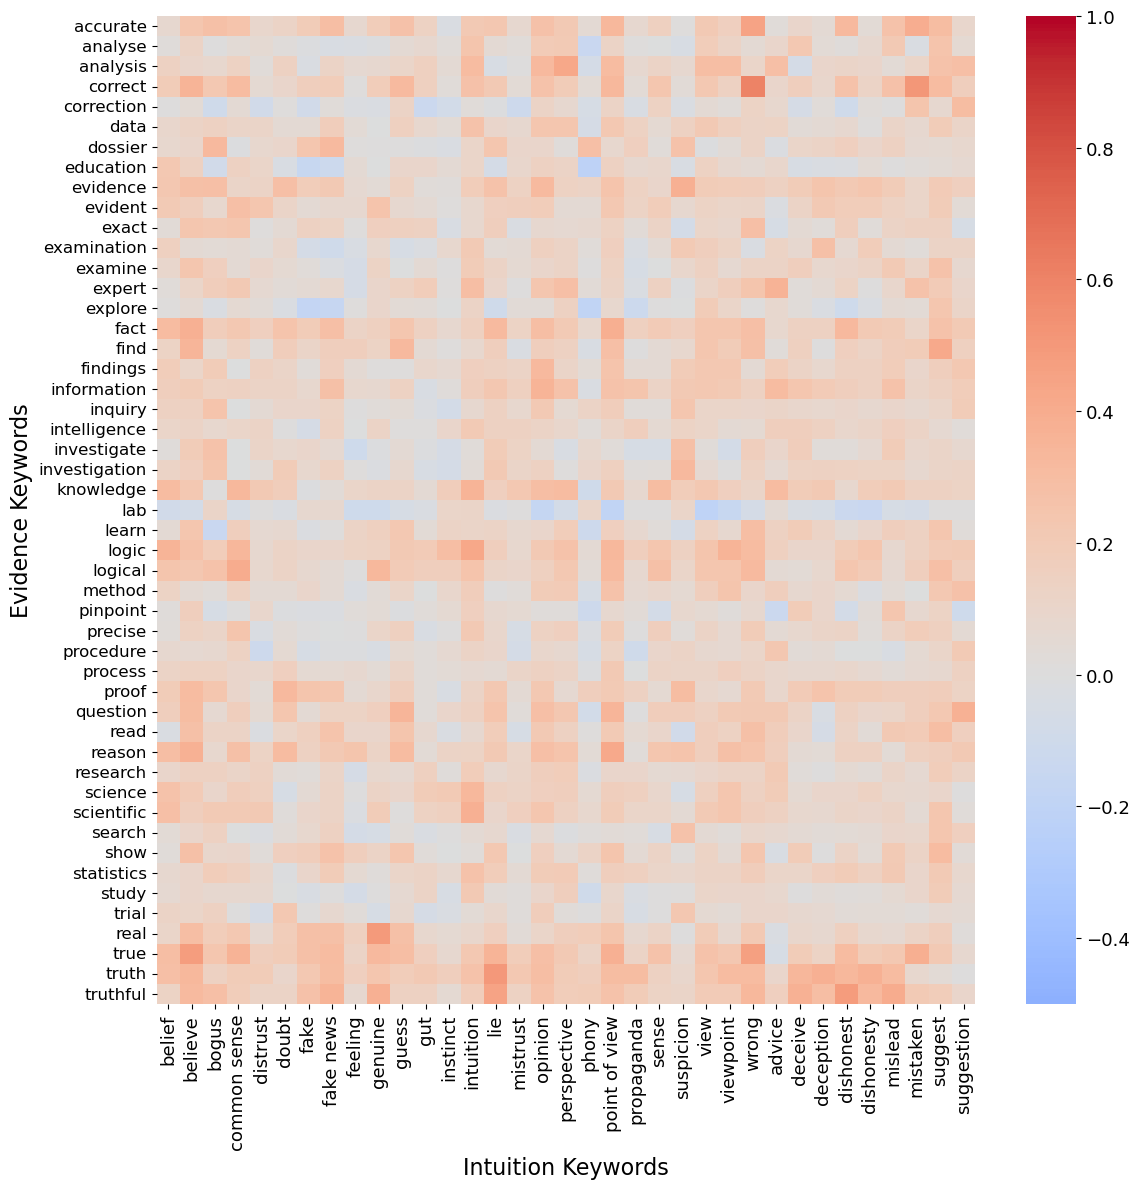

In [43]:
# Compute cosine similarity matrix
ft_similarity_matrix = cosine_similarity(
    list(df_evidence['embedding_ft']), 
    list(df_intuition['embedding_ft'])
)

# Convert to DataFrame with word labels
ft_similarity_df = pd.DataFrame(
    ft_similarity_matrix, 
    index=df_evidence['word'], 
    columns=df_intuition['word']
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(
    ft_similarity_df, 
    annot=False, 
    cmap="coolwarm", 
    xticklabels=True, 
    yticklabels=True, 
    vmin=-0.5, vmax=1, center=0,
    ax=ax,
    #cbar_kws={'shrink': 0.8}  # Optional: shrink colorbar if too large
)

# Labels
ax.set_xlabel("Intuition Keywords", fontsize=16)
ax.set_ylabel("Evidence Keywords", fontsize=16)

# Set tick label font sizes
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=12)

# Set colorbar tick label size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=13)

# Layout and export
plt.tight_layout()
plt.savefig("Dictionary_CosSim_Heatmap_finetuned.pdf", bbox_inches='tight')
plt.show()


## **Cosine Similarity between Dictionary Words, Self Build Model**

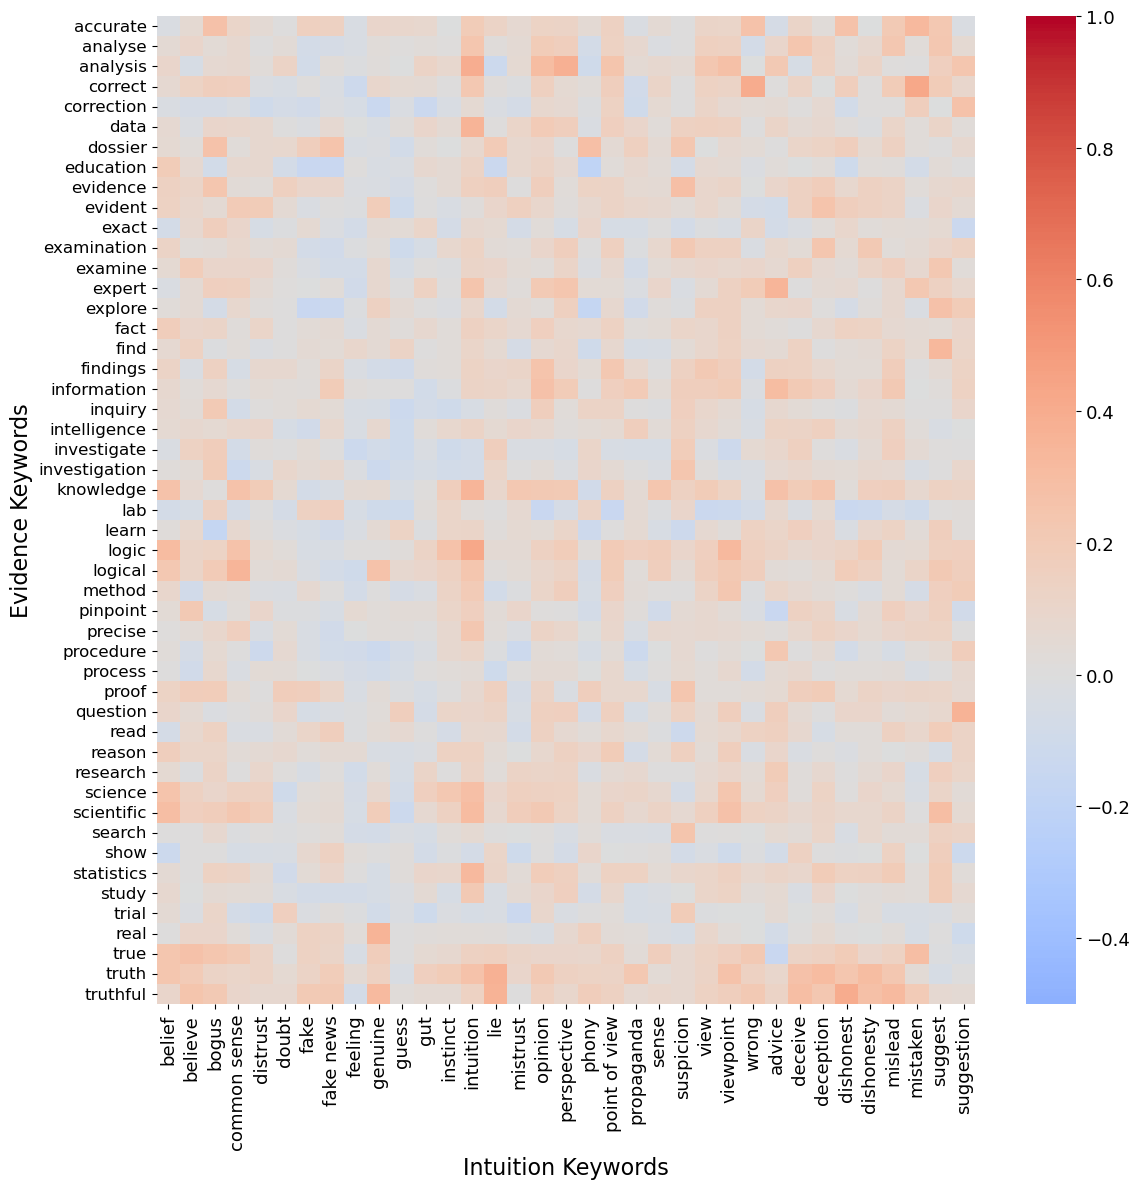

In [29]:
# Compute cosine similarity matrix
self_similarity_matrix = cosine_similarity(
    list(df_evidence['embedding_sb']), 
    list(df_intuition['embedding_sb'])
)

# Convert to DataFrame with word labels
self_similarity_df = pd.DataFrame(
    self_similarity_matrix, 
    index=df_evidence['word'], 
    columns=df_intuition['word']
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(
    self_similarity_df, 
    annot=False, 
    cmap="coolwarm", 
    xticklabels=True, 
    yticklabels=True, 
    vmin=-0.5, vmax=1, center=0,
    ax=ax,
    #cbar_kws={'shrink': 0.8}  # Optional: shrink colorbar if too large
)

# Labels
ax.set_xlabel("Intuition Keywords", fontsize=16)
ax.set_ylabel("Evidence Keywords", fontsize=16)

# Set tick label font sizes
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=12)

# Set colorbar tick label size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=13)

# Layout and export
plt.tight_layout()
plt.savefig("Dictionary_CosSim_Heatmap_selfbuild.pdf", bbox_inches='tight')
plt.show()


**Interpretation:**

* not necessarily a problem $\to$ E and I scores are correlated
    * $\to$ I am kind of hesitant of how much the words are similar in the finetuned embeddings
 
* My goal was to maybe fine individual words that are "too" similar to the other dictionary
 
* David: self trained model: wayy to little text (93.219 texts)

## **Cosine similarity of each Dictionary word**

In [19]:
# compute cosine similarity
evi["base_word_I"] = evi.apply(lambda row: compute_cosine_similarity(row, "base_embeddings", base_intuition_embeddings), axis=1)
evi["base_word_E"] = evi.apply(lambda row: compute_cosine_similarity(row, "base_embeddings", base_evidence_embeddings), axis=1)

evi["finetuned_word_I"] = evi.apply(lambda row: compute_cosine_similarity(row, "ft_embeddings", finetuned_intuition_embeddings), axis=1)
evi["finetuned_word_E"] = evi.apply(lambda row: compute_cosine_similarity(row, "ft_embeddings", finetuned_evidence_embeddings), axis=1)

evi["self_word_I"] = evi.apply(lambda row: compute_cosine_similarity(row, "self_embeddings", self_intuition_embeddings), axis=1)
evi["self_word_E"] = evi.apply(lambda row: compute_cosine_similarity(row, "self_embeddings", self_evidence_embeddings), axis=1)



intu["base_word_I"] = intu.apply(lambda row: compute_cosine_similarity(row, "base_embeddings", base_intuition_embeddings), axis=1)
intu["base_word_E"] = intu.apply(lambda row: compute_cosine_similarity(row, "base_embeddings", base_evidence_embeddings), axis=1)

intu["finetuned_word_I"] = intu.apply(lambda row: compute_cosine_similarity(row, "ft_embeddings", finetuned_intuition_embeddings), axis=1)
intu["finetuned_word_E"] = intu.apply(lambda row: compute_cosine_similarity(row, "ft_embeddings", finetuned_evidence_embeddings), axis=1)

intu["self_word_I"] = intu.apply(lambda row: compute_cosine_similarity(row, "self_embeddings", self_intuition_embeddings), axis=1)
intu["self_word_E"] = intu.apply(lambda row: compute_cosine_similarity(row, "self_embeddings", self_evidence_embeddings), axis=1)


In [21]:
#evi
#intu

## **E or I words, that are more similar to the other**

**Base Model**

In [20]:
print(f"{len(evi[evi['base_word_E']< evi['base_word_I']])} out of {len(evi)} evidence-words have higher I than E similarity")
print(evi[evi['base_word_E']< evi['base_word_I']]['keywords'])
print("\n--------------\n")

print(f"{len(intu[intu['base_word_I']< intu['base_word_E']])} out of {len(intu)} intuition-words have higher E than I similarity")
print(intu[intu['base_word_I']< intu['base_word_E']]['keywords'])

3 out of 49 evidence-words have higher I than E similarity
36      reason
47       truth
48    truthful
Name: keywords, dtype: object

--------------

7 out of 35 intuition-words have higher E than I similarity
3      common sense
7         fake news
17      perspective
19    point of view
23             view
26           advice
33          suggest
Name: keywords, dtype: object


**Finetuned Model**

In [21]:
print(f"{len(evi[evi['finetuned_word_E']< evi['finetuned_word_I']])} out of {len(evi)} evidence-words have higher I than E similarity")
print(evi[evi['finetuned_word_E']< evi['finetuned_word_I']]['keywords'])
print("\n--------------\n")

print(f"{len(intu[intu['finetuned_word_I']< intu['finetuned_word_E']])} out of {len(intu)} intuition-words have higher E than I similarity")
print(intu[intu['finetuned_word_I']< intu['finetuned_word_E']]['keywords'])
print((25/35))

1 out of 49 evidence-words have higher I than E similarity
48    truthful
Name: keywords, dtype: object

--------------

16 out of 35 intuition-words have higher E than I similarity
1           believe
3      common sense
5             doubt
6              fake
7         fake news
9           genuine
10            guess
16          opinion
17      perspective
19    point of view
21            sense
23             view
25            wrong
26           advice
33          suggest
34       suggestion
Name: keywords, dtype: object
0.7142857142857143


**Self build Model**

In [22]:
print(f"{len(evi[evi['self_word_E']< evi['self_word_I']])} out of {len(evi)} evidence-words have higher I than E similarity")
print(evi[evi['self_word_E']< evi['self_word_I']]['keywords'])
print("\n--------------\n")

print(f"{len(intu[intu['self_word_I']< intu['self_word_E']])} out of {len(intu)} intuition-words have higher E than I similarity")
print(intu[intu['self_word_I']< intu['self_word_E']]['keywords'])


10 out of 49 evidence-words have higher I than E similarity
16        find
25       learn
26       logic
27     logical
34    question
36      reason
41        show
45        real
47       truth
48    truthful
Name: keywords, dtype: object

--------------

1 out of 35 intuition-words have higher E than I similarity
26    advice
Name: keywords, dtype: object


***
**Interpretation:**

* **Base Model**
    * I have the evidence words *truthful, truth* and *reason* which have a higher similarity to the intuition-dictionary, than to the evidence-dictionary
    * When in the text, the text will be rather classified as intuition, than evidence
    * For intuition, even more words
* **Finetuned Model**
    * only *truthful* is more similar to I, than E
    * 15 out of 35 intuition words (71%) are more similar to E than I
        * they will lift up the E scores

***

## **Correlations of the three models' raw scores per dictionary**

#### **Evidence Dictionary**

In [23]:
corr = evi[['base_word_E', 'base_word_I', 'finetuned_word_E', 'finetuned_word_I', 'self_word_E', 'self_word_I']].corr()

corr.style.background_gradient(cmap='Blues').set_caption("E-Dictionary: Correlation Matrix raw E and I")


,base_word_E,base_word_I,finetuned_word_E,finetuned_word_I,self_word_E,self_word_I
base_word_E,1.000000,0.760965,0.902473,0.786972,0.115812,0.010560
base_word_I,0.760965,1.000000,0.806387,0.905607,-0.039137,0.171176
finetuned_word_E,0.902473,0.806387,1.000000,0.948358,0.080142,0.037763
finetuned_word_I,0.786972,0.905607,0.948358,1.000000,0.022903,0.131827
self_word_E,0.115812,-0.039137,0.080142,0.022903,1.000000,0.793635
self_word_I,0.010560,0.171176,0.037763,0.131827,0.793635,1.000000


#### **Intuition Dictionary**

In [24]:
corr = intu[['base_word_E', 'base_word_I', 'finetuned_word_E', 'finetuned_word_I', 'self_word_E', 'self_word_I']].corr()

corr.style.background_gradient(cmap='Blues').set_caption("I-Dictionary: Correlation Matrix raw E and I")



,base_word_E,base_word_I,finetuned_word_E,finetuned_word_I,self_word_E,self_word_I
base_word_E,1.000000,0.882203,0.944044,0.897136,-0.177999,-0.129366
base_word_I,0.882203,1.000000,0.844917,0.892221,-0.142233,-0.069970
finetuned_word_E,0.944044,0.844917,1.000000,0.976677,-0.200353,-0.074368
finetuned_word_I,0.897136,0.892221,0.976677,1.000000,-0.159367,-0.006931
self_word_E,-0.177999,-0.142233,-0.200353,-0.159367,1.000000,0.931225
self_word_I,-0.129366,-0.069970,-0.074368,-0.006931,0.931225,1.000000


## **Scatterplots of E vs. I in the three models**

### **Evidence**

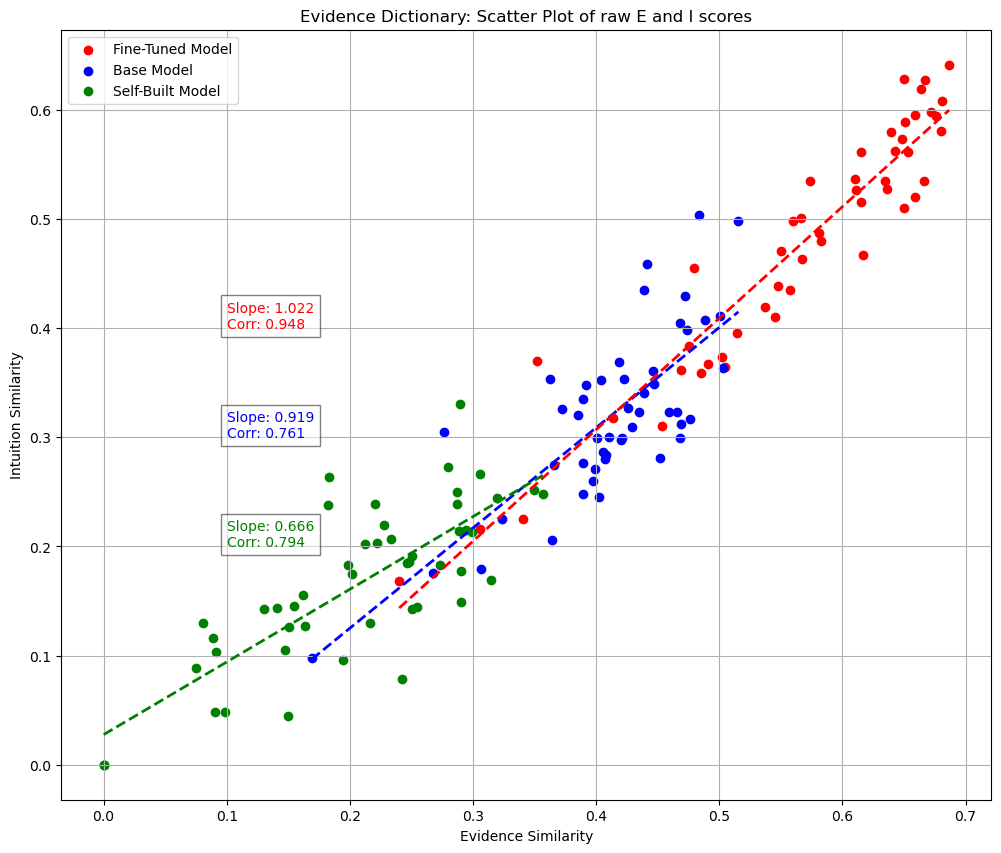

In [25]:
# Scatter plots
plt.figure(figsize=(12, 10))

plt.scatter(evi['finetuned_word_E'], evi['finetuned_word_I'], color='red', label='Fine-Tuned Model')
plt.scatter(evi['base_word_E'], evi['base_word_I'], color='blue', label='Base Model')
plt.scatter(evi['self_word_E'], evi['self_word_I'], color='green', label='Self-Built Model')

def plot_regression(x, y, color, label_pos):
    # Fit linear regression (y = mx + b)
    slope, intercept = np.polyfit(x, y, 1)
    poly_eq = np.poly1d([slope, intercept])  

    # Compute Pearson correlation coefficient
    corr, _ = pearsonr(x, y)

    # Generate regression line points
    x_range = np.linspace(min(x), max(x), 100)
    y_pred = poly_eq(x_range)

    # Plot regression line
    plt.plot(x_range, y_pred, color=color, linestyle='dashed', linewidth=2)

    # Display slope & correlation
    plt.text(label_pos[0], label_pos[1], f"Slope: {slope:.3f}\nCorr: {corr:.3f}", 
             fontsize=10, color=color, bbox=dict(facecolor='white', alpha=0.5))

# Add regression lines and annotations
plot_regression(evi['base_word_E'], evi['base_word_I'], 'blue', label_pos=(0.1, 0.3))
plot_regression(evi['finetuned_word_E'], evi['finetuned_word_I'], 'red', label_pos=(0.1, 0.4))
plot_regression(evi['self_word_E'], evi['self_word_I'], 'green', label_pos=(0.1, 0.2))

# Labels, title, and legend
plt.xlabel("Evidence Similarity")
plt.ylabel("Intuition Similarity")
plt.title("Evidence Dictionary: Scatter Plot of raw E and I scores")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### **Intuition**

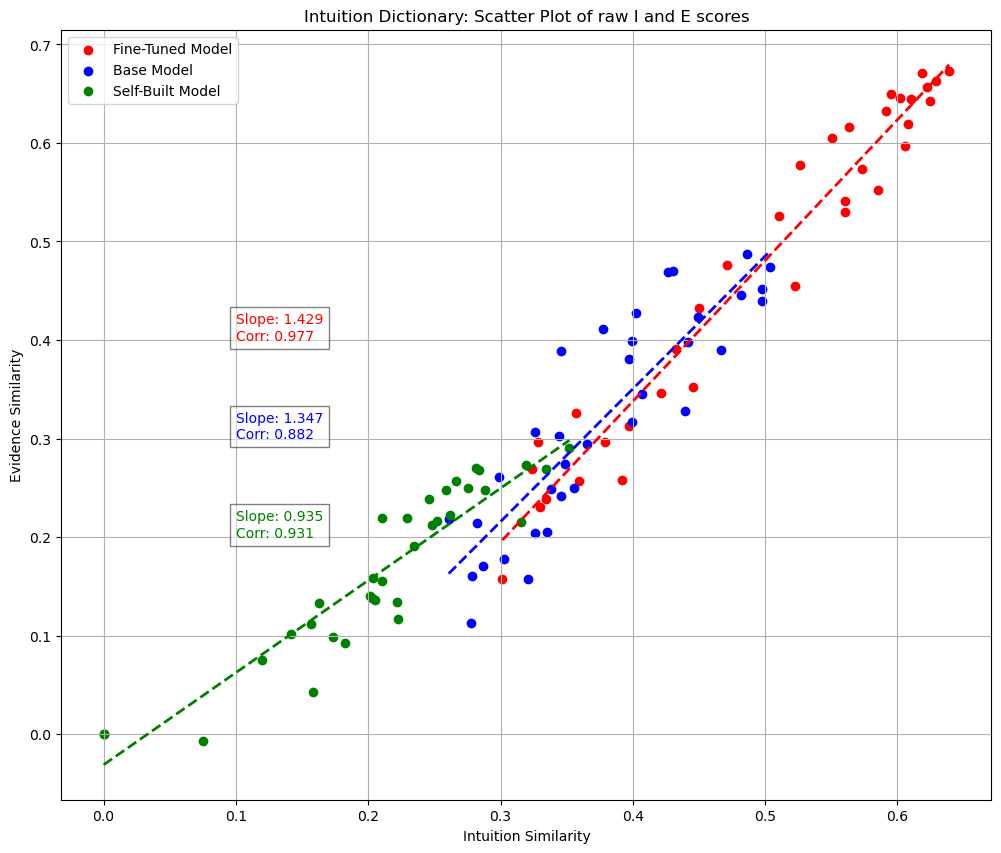

In [26]:
# Scatter plots
plt.figure(figsize=(12, 10))

plt.scatter(intu['finetuned_word_I'], intu['finetuned_word_E'], color='red', label='Fine-Tuned Model')
plt.scatter(intu['base_word_I'], intu['base_word_E'], color='blue', label='Base Model')
plt.scatter(intu['self_word_I'], intu['self_word_E'], color='green', label='Self-Built Model')

def plot_regression(x, y, color, label_pos):
    # Fit linear regression (y = mx + b)
    slope, intercept = np.polyfit(x, y, 1)
    poly_eq = np.poly1d([slope, intercept])  

    # Compute Pearson correlation coefficient
    corr, _ = pearsonr(x, y)

    # Generate regression line points
    x_range = np.linspace(min(x), max(x), 100)
    y_pred = poly_eq(x_range)

    # Plot regression line
    plt.plot(x_range, y_pred, color=color, linestyle='dashed', linewidth=2)

    # Display slope & correlation
    plt.text(label_pos[0], label_pos[1], f"Slope: {slope:.3f}\nCorr: {corr:.3f}", 
             fontsize=10, color=color, bbox=dict(facecolor='white', alpha=0.5))

# Add regression lines and annotations
plot_regression(intu['base_word_I'], intu['base_word_E'], 'blue', label_pos=(0.1, 0.3))
plot_regression(intu['finetuned_word_I'], intu['finetuned_word_E'], 'red', label_pos=(0.1, 0.4))
plot_regression(intu['self_word_I'], intu['self_word_E'], 'green', label_pos=(0.1, 0.2))

# Labels, title, and legend
plt.xlabel("Intuition Similarity")
plt.ylabel("Evidence Similarity")
plt.title("Intuition Dictionary: Scatter Plot of raw I and E scores")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


**Interpretation**

* embedded both dictionaries with three models
* computed cosine similarities of each dictionary word to both dictionaries

* raw scores are overall lower in self, than base, than finetuned model

* what we would like
    * high evidence similarity with low intuition similarity --> easy to distinguish
    * would need a negative slope 